In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn import preprocessing as prep
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import PolynomialFeatures
import scipy.stats as stats

In [58]:
df = pd.read_csv('life_expectancy.csv')

print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1649 entries, 0 to 1648
Data columns (total 21 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Unnamed: 0                       1649 non-null   int64  
 1   CountryStatus                    1649 non-null   object 
 2   Life expectancy                  1649 non-null   float64
 3   Adult Mortality                  1649 non-null   float64
 4   infant deaths                    1649 non-null   int64  
 5   Alcohol                          1649 non-null   float64
 6   percentage expenditure           1649 non-null   float64
 7   Hepatitis B                      1649 non-null   float64
 8   Measles                          1649 non-null   int64  
 9    BMI                             1649 non-null   float64
 10  under-five deaths                1649 non-null   int64  
 11  Polio                            1649 non-null   float64
 12  Total expenditure   

In [59]:
print(df.describe())

        Unnamed: 0  Life expectancy   Adult Mortality  infant deaths  \
count  1649.000000       1649.000000      1649.000000    1649.000000   
mean   1423.459673         69.302304       168.215282      32.553062   
std     843.967342          8.796834       125.310417     120.847190   
min       0.000000         44.000000         1.000000       0.000000   
25%     649.000000         64.400000        77.000000       1.000000   
50%    1462.000000         71.700000       148.000000       3.000000   
75%    2124.000000         75.000000       227.000000      22.000000   
max    2937.000000         89.000000       723.000000    1600.000000   

           Alcohol  percentage expenditure  Hepatitis B       Measles   \
count  1649.000000             1649.000000  1649.000000    1649.000000   
mean      4.533196              698.973558    79.217708    2224.494239   
std       4.029189             1759.229336    25.604664   10085.802019   
min       0.010000                0.000000     2.000000

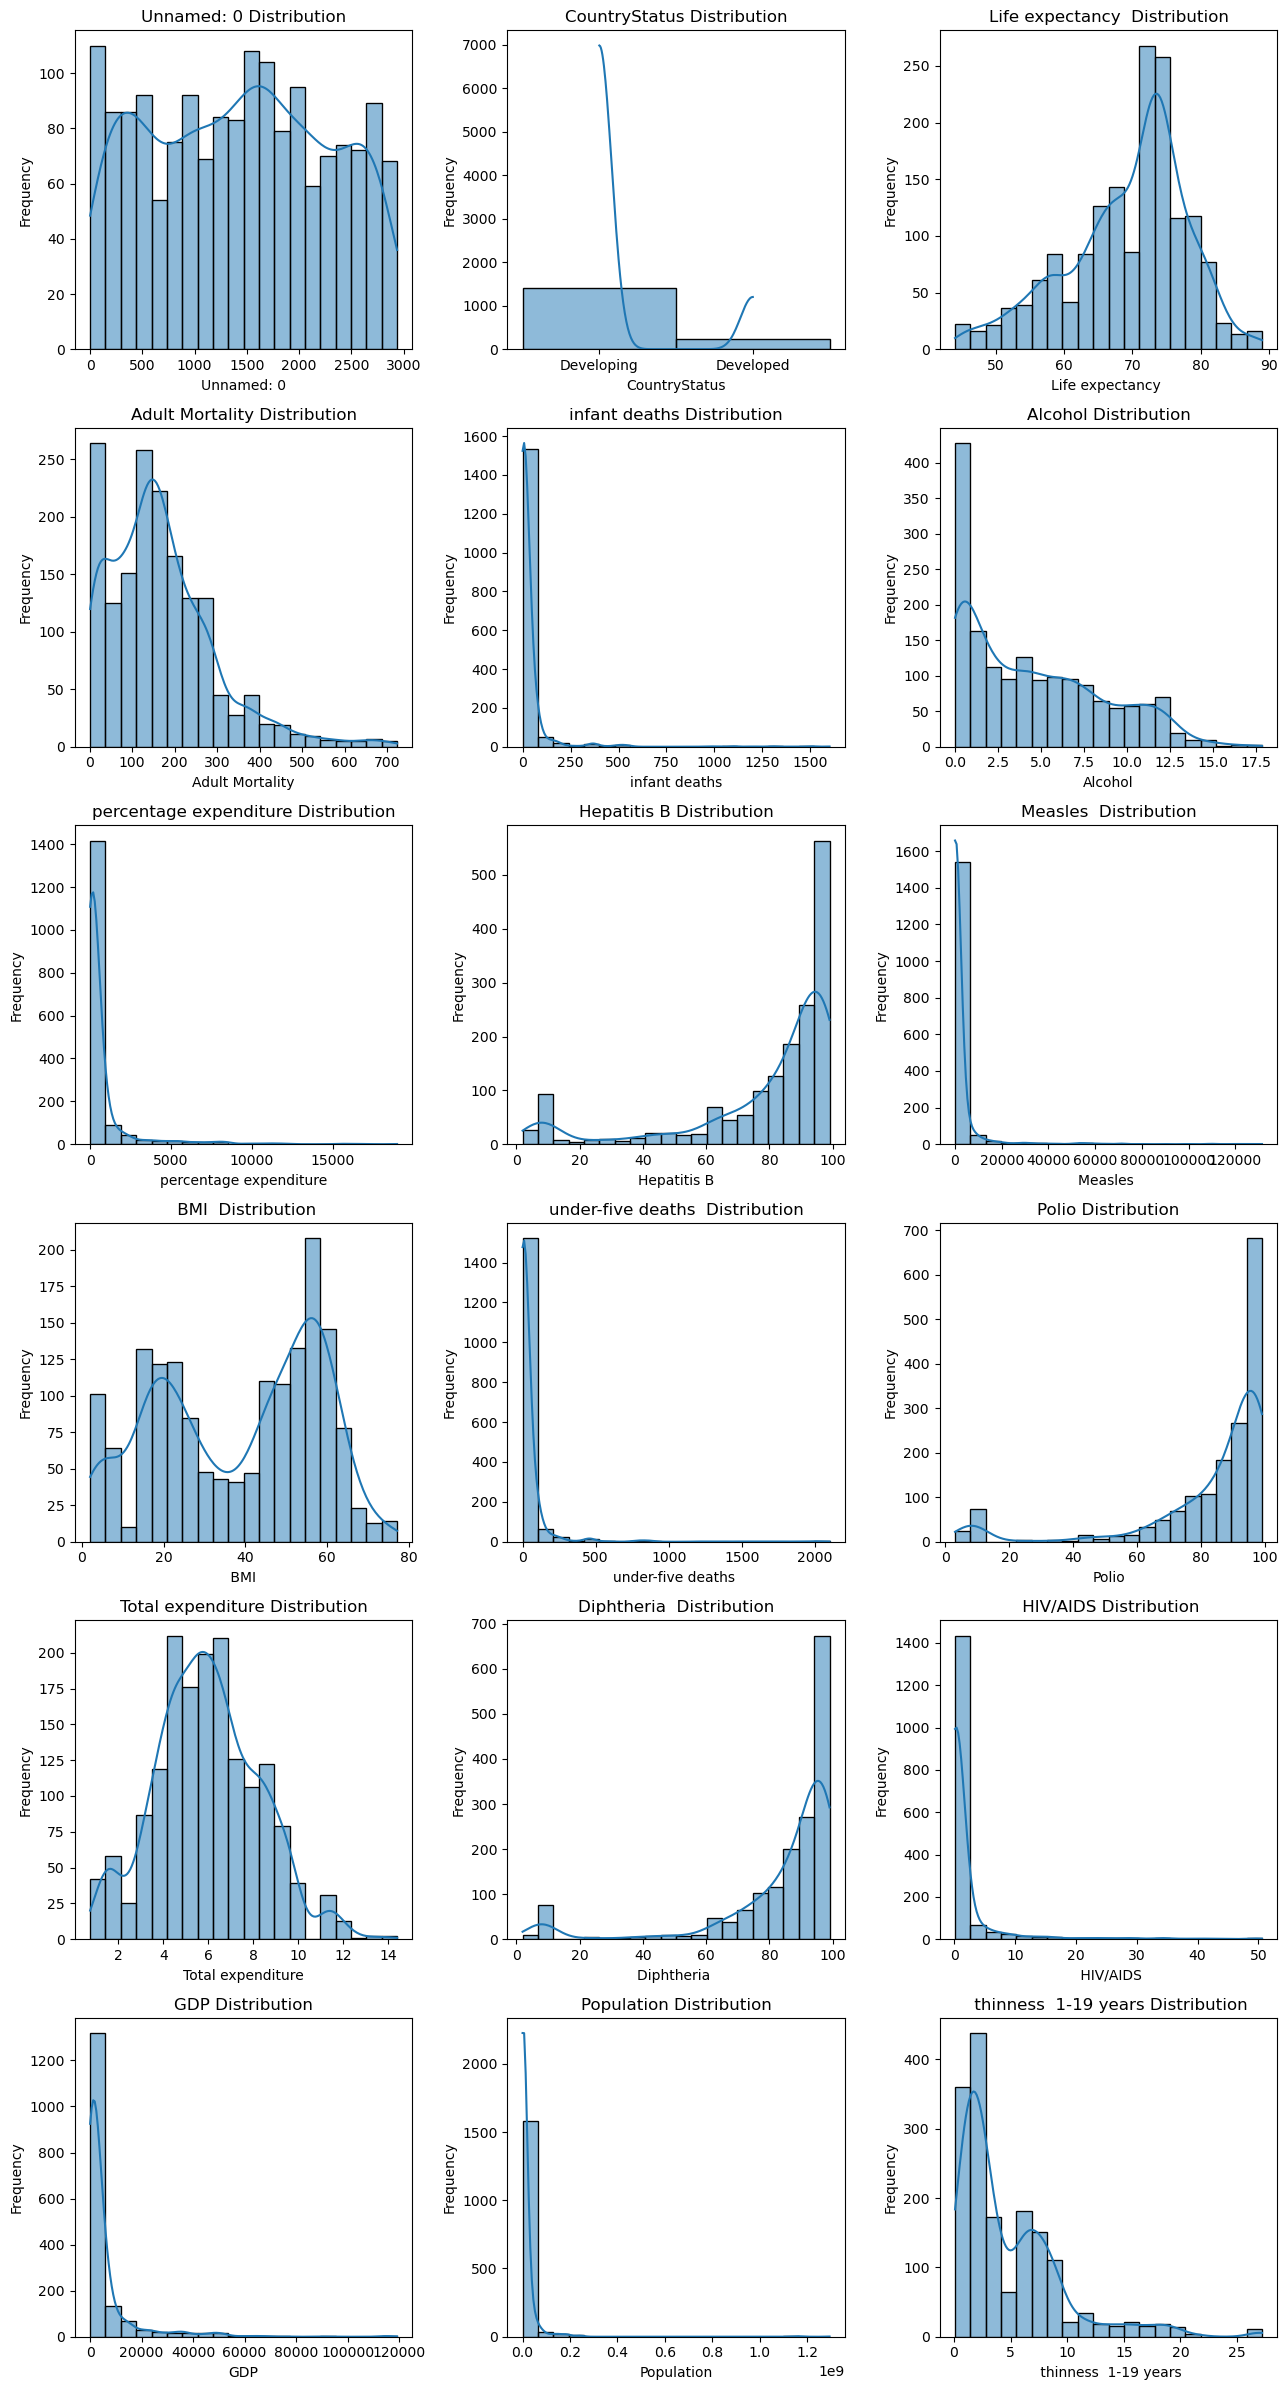

In [60]:
num_features = 18
cols = 3
rows = (num_features + cols - 1)// cols #round up output of calculation to ensure the min # is satisfied

plt.figure(figsize=(13, rows * 4))

for i, column in enumerate(df.columns[:num_features], 1):
    plt.subplot(rows, cols, i)
    sns.histplot(df[column], kde=True, bins=20)  
    plt.title(f"{column} Distribution")  
    plt.xlabel(column)  
    plt.ylabel("Frequency")

plt.tight_layout()  
plt.show()

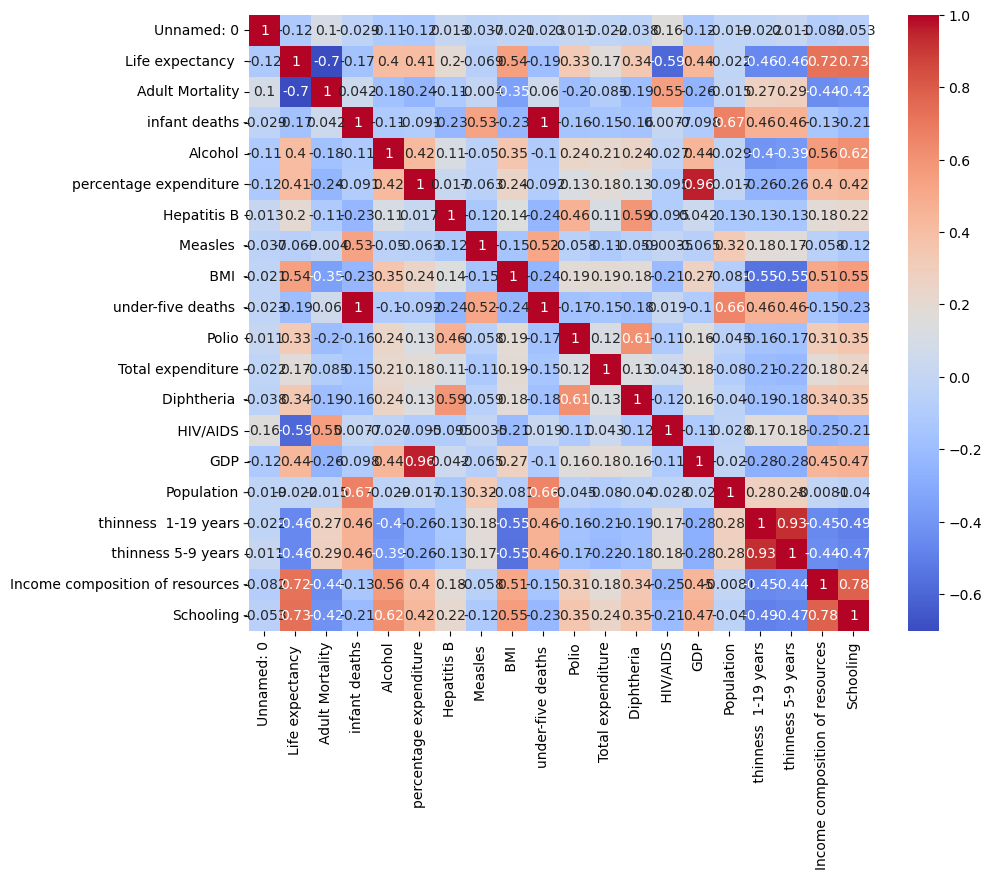

In [61]:
df_heatmap = df.drop(columns=['CountryStatus'])
plt.figure(figsize=(10, 8))
sns.heatmap(df_heatmap.corr(), annot=True, cmap="coolwarm")
plt.show()

## Reasoning for later manipulation

- features with high correlations will be removed since this is a linear model  
- features with skewed distribution will have further analysis with IQR outliers  
- features with normal (or similar) distributions will have further analysis with Z-score outliers  
- features with high variance relative to mean (since the scales are different), will be analyzed  for higher efficiency

### specific cutoffs/ decision rules are reflected in the code

In [55]:
def analyze_feature_distribution(df, feature_name):
    mean = df[feature_name].mean()
    median = df[feature_name].median()
    std = df[feature_name].std()
    cv = std / mean  

    skewness = stats.skew(df[feature_name].dropna())
    kurtosis = stats.kurtosis(df[feature_name].dropna())
    _, shapiro_p = stats.shapiro(df[feature_name].sample(min(1000, len(df[feature_name]))))

    return {
        'feature': feature_name,  # Add the feature name here
        'cv': cv,
        'skewness': skewness,
        'kurtosis': kurtosis,
        'is_normal': shapiro_p > 0.1 # this has been large enough (normally 0.05), maybe none follows normal distribution
    }

def decision_making(df, cv_threshold=1.0, skewness_threshold=0.5):
    scaled_features = df.select_dtypes(include=[np.number]).columns
    feature_analyses = []

    for feature in scaled_features:
        analysis = analyze_feature_distribution(df, feature)
        feature_analyses.append(analysis)
    
    analysis_df = pd.DataFrame(feature_analyses)
    
    normal_features = analysis_df[analysis_df['is_normal']].copy()
    skewed_features = analysis_df[~analysis_df['is_normal']].copy()
    
    normal_features = normal_features.sort_values('cv', ascending=False)
    
    skewed_features['abs_skewness'] = abs(skewed_features['skewness'])
    top_skewed = skewed_features.nlargest(5, ['abs_skewness', 'cv'])
    
    print("\nTop 5 Skewed Features:")
    print("----------------------")
    for _, row in top_skewed.iterrows():
        print(f"Feature: {row['feature']:<20} CV: {row['cv']:.2f} Skewness: {row['skewness']:.2f}")
    
    print("\nAll Normal Features:")
    print("----------------------------------")
    for _, row in normal_features.iterrows():
        print(f"Feature: {row['feature']:<20} CV: {row['cv']:.2f}")
    
    selected_features = list(top_skewed['feature']) + list(normal_features['feature'])
    return selected_features

features_for_analysis = decision_making(df)



Top 5 Skewed Features:
----------------------
Feature: Population           CV: 4.81 Skewness: 14.17
Feature: infant deaths        CV: 3.71 Skewness: 8.47
Feature: under-five deaths    CV: 3.68 Skewness: 8.33
Feature: Measles              CV: 4.53 Skewness: 7.95
Feature: percentage expenditure CV: 2.52 Skewness: 4.98

All Normal Features:
----------------------------------


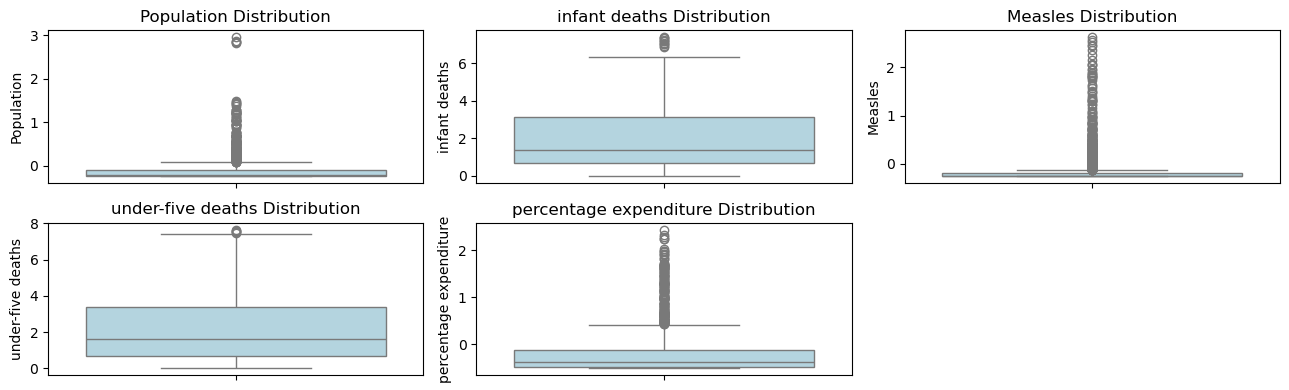


Population:
Outliers: 221 points (13.4% of data)

infant deaths:
Outliers: 11 points (0.7% of data)

Measles:
Outliers: 295 points (17.9% of data)

under-five deaths:
Outliers: 5 points (0.3% of data)

percentage expenditure:
Outliers: 160 points (9.7% of data)


In [76]:
# Boxplots
df.columns = df.columns.str.strip()
features = ['Population', 'infant deaths', 'Measles', 'under-five deaths', 'percentage expenditure']

plt.figure(figsize=(13, 4))  # Adjusted height since we only have 3 features

for i, feature in enumerate(features, 1):
    plt.subplot(2, 3, i)
    sns.boxplot(y=df[feature], color='lightblue')
    plt.title(f"{feature} Distribution")
    plt.ylabel(feature)

plt.tight_layout()
plt.show()

outliers_dict = {}

for feature in features:
 
    Q1 = df[feature].quantile(0.25)
    Q3 = df[feature].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    outlier_rows = df[(df[feature] < lower_bound) | (df[feature] > upper_bound)]
    outliers_dict[feature] = df[(df[feature] < lower_bound) | (df[feature] > upper_bound)].index.tolist()
    
 
    print(f"\n{feature}:")
    print(f"Outliers: {len(outlier_rows)} points ({(len(outlier_rows)/len(df)*100):.1f}% of data)")

some of the outliers cannot be removed due to high proportion .
some need further analysis to decide whether can be removed or not.  


In [77]:
for feature in ['infant deaths', 'under-five deaths']:
    if feature in outliers_dict:
        print(f"\nOutlier locations for '{feature}': {outliers_dict[feature]}")


Outlier locations for 'infant deaths': [664, 665, 666, 667, 668, 669, 670, 671, 672, 673, 674]

Outlier locations for 'under-five deaths': [670, 671, 672, 673, 674]


__Consecutive outliers indicate it is highly possible that there are error in recording/ mesuring during certain period.__  

### Thus, outliers can be removed

since these two are highlt skewed, use median to remove outliers


In [78]:
target_features = ['infant deaths', 'under-five deaths']

for feature in target_features:

    Q1 = df[feature].quantile(0.25)
    Q3 = df[feature].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    median_value = df[feature].median()
    
    # Replace outliers with the median
    df.loc[(df[feature] < lower_bound) | (df[feature] > upper_bound), feature] = median_value

In [79]:
df.columns.tolist()

['Unnamed: 0',
 'CountryStatus',
 'Life expectancy',
 'Adult Mortality',
 'infant deaths',
 'Alcohol',
 'percentage expenditure',
 'Hepatitis B',
 'Measles',
 'BMI',
 'under-five deaths',
 'Polio',
 'Total expenditure',
 'Diphtheria',
 'HIV/AIDS',
 'GDP',
 'Population',
 'thinness  1-19 years',
 'thinness 5-9 years',
 'Income composition of resources',
 'Schooling']

### Scaling Reasoning

According to previous analysis, those with
- high variance
- unit biases
- outliers/ high skewed

__here we choose top3 in ealier analysis__  
__and variance magnitude larger than thereholds (0.75)__


Coefficient of Variation (CV) after scaling (should have zero mean):
Population               -1.547643e+16
infant deaths            -2.579406e+16
Measles                  -1.160733e+16
under-five deaths        -2.579406e+16
percentage expenditure   -2.321465e+16
dtype: float64


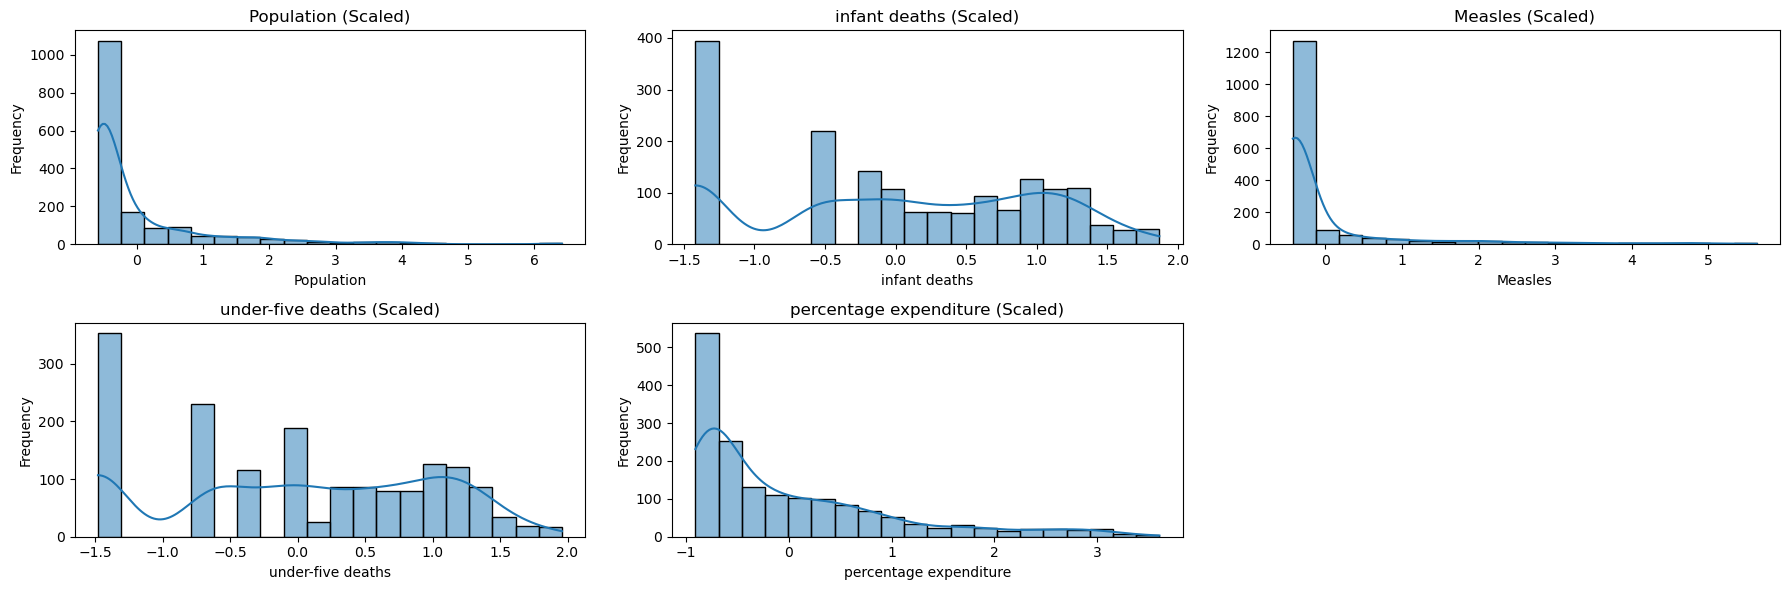

In [84]:
# Top5 CV & Skewness

scaled_features = df[['Population', 'infant deaths', 'Measles', 'under-five deaths', 'percentage expenditure']]

scaler = StandardScaler()
scaled_data = pd.DataFrame(scaler.fit_transform(scaled_features), columns=scaled_features.columns)

cv_after_scaling = scaled_data.std() / scaled_data.mean()
print("\nCoefficient of Variation (CV) after scaling (should have zero mean):")
print(cv_after_scaling)

plt.figure(figsize=(18, 6))

for i, column in enumerate(scaled_data.columns, 1):
    plt.subplot(2, 3, i)
    sns.histplot(scaled_data[column], kde=True, bins=20)
    plt.title(f"{column} (Scaled)")
    plt.xlabel(column)
    plt.ylabel("Frequency")

plt.tight_layout()
plt.show()

- CV seems to even higher, and still highly skewed, whcih indicates transformation is necessary

In [81]:
df1 = df.drop('CountryStatus', axis=1)

variances = df1.var()

variance_threshold = variances.quantile(0.75)  
high_variance_features = variances[variances > variance_threshold].index


print("Variances before scaling for selected high-variance features:")
print(variances[high_variance_features])

scaler = StandardScaler()
df1[high_variance_features] = scaler.fit_transform(df1[high_variance_features])

variances_after = df1.var()
print('After:')
print(variances_after[high_variance_features])

Variances before scaling for selected high-variance features:
Adult Mortality    15702.700592
Hepatitis B          655.598812
BMI                  390.230370
Polio                504.027531
Diphtheria           465.661564
dtype: float64
After:
Adult Mortality    1.000607
Hepatitis B        1.000607
BMI                1.000607
Polio              1.000607
Diphtheria         1.000607
dtype: float64


The Stds significantly decrease  
__We can apply scaler to these features__

In [82]:
df[high_variance_features] = scaler.fit_transform(df[high_variance_features])

df.describe()

,Unnamed: 0,Life expectancy,Adult Mortality,infant deaths,Alcohol,percentage expenditure,Hepatitis B,Measles,BMI,under-five deaths,Polio,Total expenditure,Diphtheria,HIV/AIDS,GDP,Population,thinness 1-19 years,thinness 5-9 years,Income composition of resources,Schooling
count,1.649000e+03,1649.000000,1.649000e+03,1649.000000,1649.000000,1649.000000,1.649000e+03,1649.000000,1.649000e+03,1649.000000,1.649000e+03,1649.000000,1.649000e+03,1649.000000,1649.000000,1649.000000,1649.000000,1649.000000,1649.000000,1649.000000
mean,1.378858e-16,69.302304,-7.756076e-17,1.807015,4.533196,-0.183561,1.637394e-16,-0.122727,-6.894290e-17,1.998377,2.574586e-16,5.955925,1.292679e-17,0.518074,-0.211144,-0.089342,4.850637,4.907762,0.631551,12.119891
std,1.000303e+00,8.796834,1.000303e+00,1.590709,4.029189,0.486862,1.000303e+00,0.362669,1.000303e+00,1.724494,1.000303e+00,2.299385,1.000303e+00,0.800281,0.543332,0.308820,4.599228,4.653757,0.183089,2.795388
min,-1.687140e+00,44.000000,-1.334813e+00,0.000000,0.010000,-0.506566,-3.016682e+00,-0.249262,-1.829459e+00,0.000000,-3.589622e+00,0.740000,-3.808306e+00,0.095310,-0.663627,-0.233235,0.100000,0.100000,0.000000,4.200000
25%,-9.179201e-01,64.400000,-7.281354e-01,0.693147,0.810000,-0.471847,-2.038414e-01,-0.249262,-9.433046e-01,0.693147,-1.142672e-01,4.410000,-9.990640e-02,0.095310,-0.588576,-0.229801,1.600000,1.700000,0.509000,10.300000
50%,4.567951e-02,71.700000,-1.613706e-01,1.386294,3.790000,-0.378239,3.821671e-01,-0.247355,2.821199e-01,1.609438,4.204028e-01,5.840000,3.636435e-01,0.095310,-0.425182,-0.208106,3.000000,3.200000,0.673000,12.300000
75%,8.303080e-01,75.000000,4.692551e-01,3.091042,7.340000,-0.114063,6.556377e-01,-0.202888,8.948321e-01,3.367296,5.986262e-01,7.470000,5.954185e-01,0.530628,-0.076745,-0.104584,7.100000,7.100000,0.751000,14.000000
max,1.793908e+00,89.000000,4.428626e+00,6.322565,17.870000,2.432213,7.728394e-01,2.625799,1.973408e+00,7.438972,6.877378e-01,14.390000,6.881285e-01,3.943522,2.389001,2.952849,27.200000,28.200000,0.936000,20.700000


### Reasoning for Transformation

- Highly skewed, and many outliers data need to be transformed, we use log transformation here since they are all highly skewed (larger than 4)

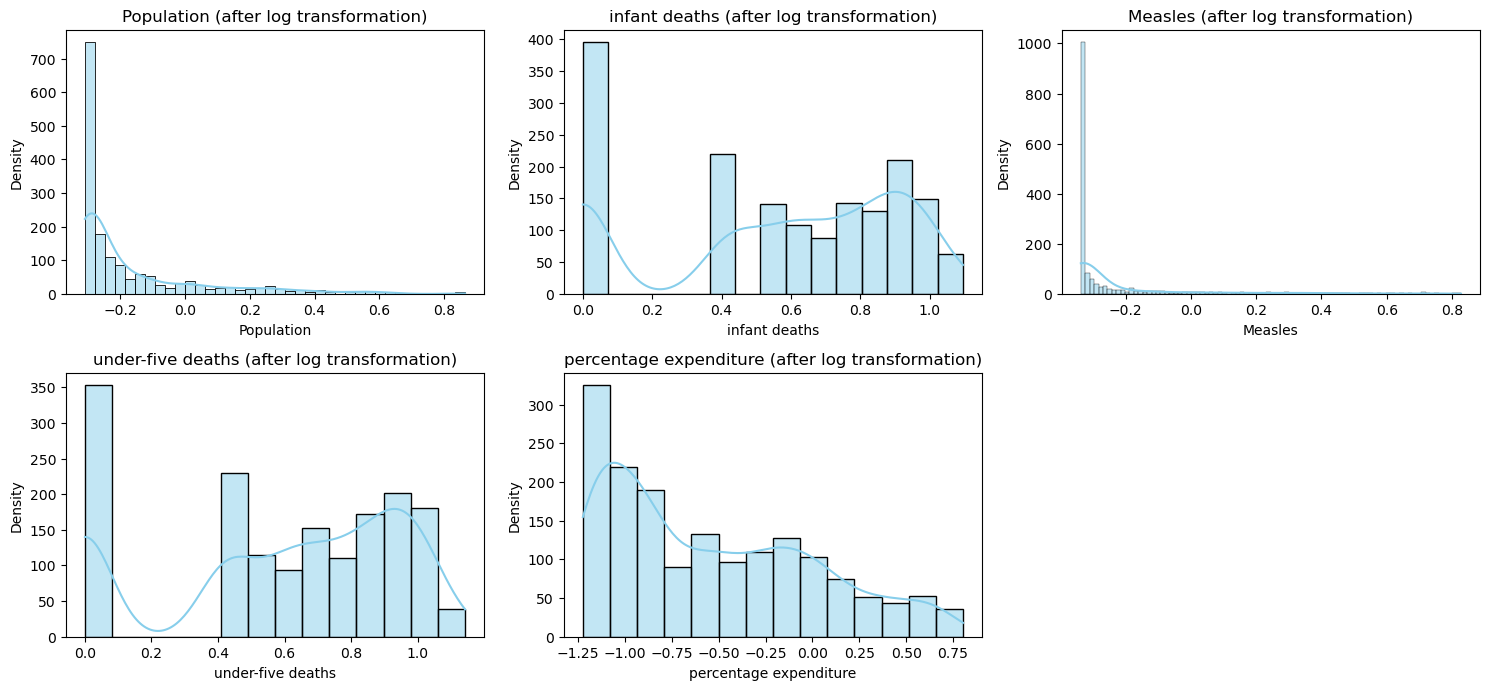

In [85]:
features_to_transform = ['Population', 'infant deaths', 'Measles', 'under-five deaths', 'percentage expenditure']

for feature in features_to_transform:
    if feature in df.columns:
        df[feature] = np.log1p(df[feature])

plt.figure(figsize=(15, 10))
for i, feature in enumerate(features_to_transform, 1):
    plt.subplot(3, 3, i)
    sns.histplot(df[feature], kde=True, color="skyblue")
    plt.title(f"{feature} (after log transformation)")
    plt.xlabel(feature)
    plt.ylabel("Density")

plt.tight_layout()
plt.show()

## Still Skewed, but better

now outliers, scaling, transformation has been processed and justified (both before and after)

### Since normality is not statisfied
following assumptions are tested:  
- linearity
- Homoscedasticity
- Independence  

__Residual Plots can visualize in most cases__

In [91]:
# Building the model
# One-hot encoding

# I cannot find out which step I delete the categorical column, so I have to read again and merge
df2 = pd.read_csv('life_expectancy.csv')
col = df2['CountryStatus']
df = df.join(col)

df = pd.get_dummies(df, columns=['CountryStatus'], prefix='CountryStatus')

# Split dataset and specify response var
X = df.drop(columns=['Life expectancy']) 
y = df['Life expectancy']


X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

print("Training set:", X_train.shape, y_train.shape)
print("Validation set:", X_val.shape, y_val.shape)

Training set: (1319, 23) (1319,)
Validation set: (330, 23) (330,)


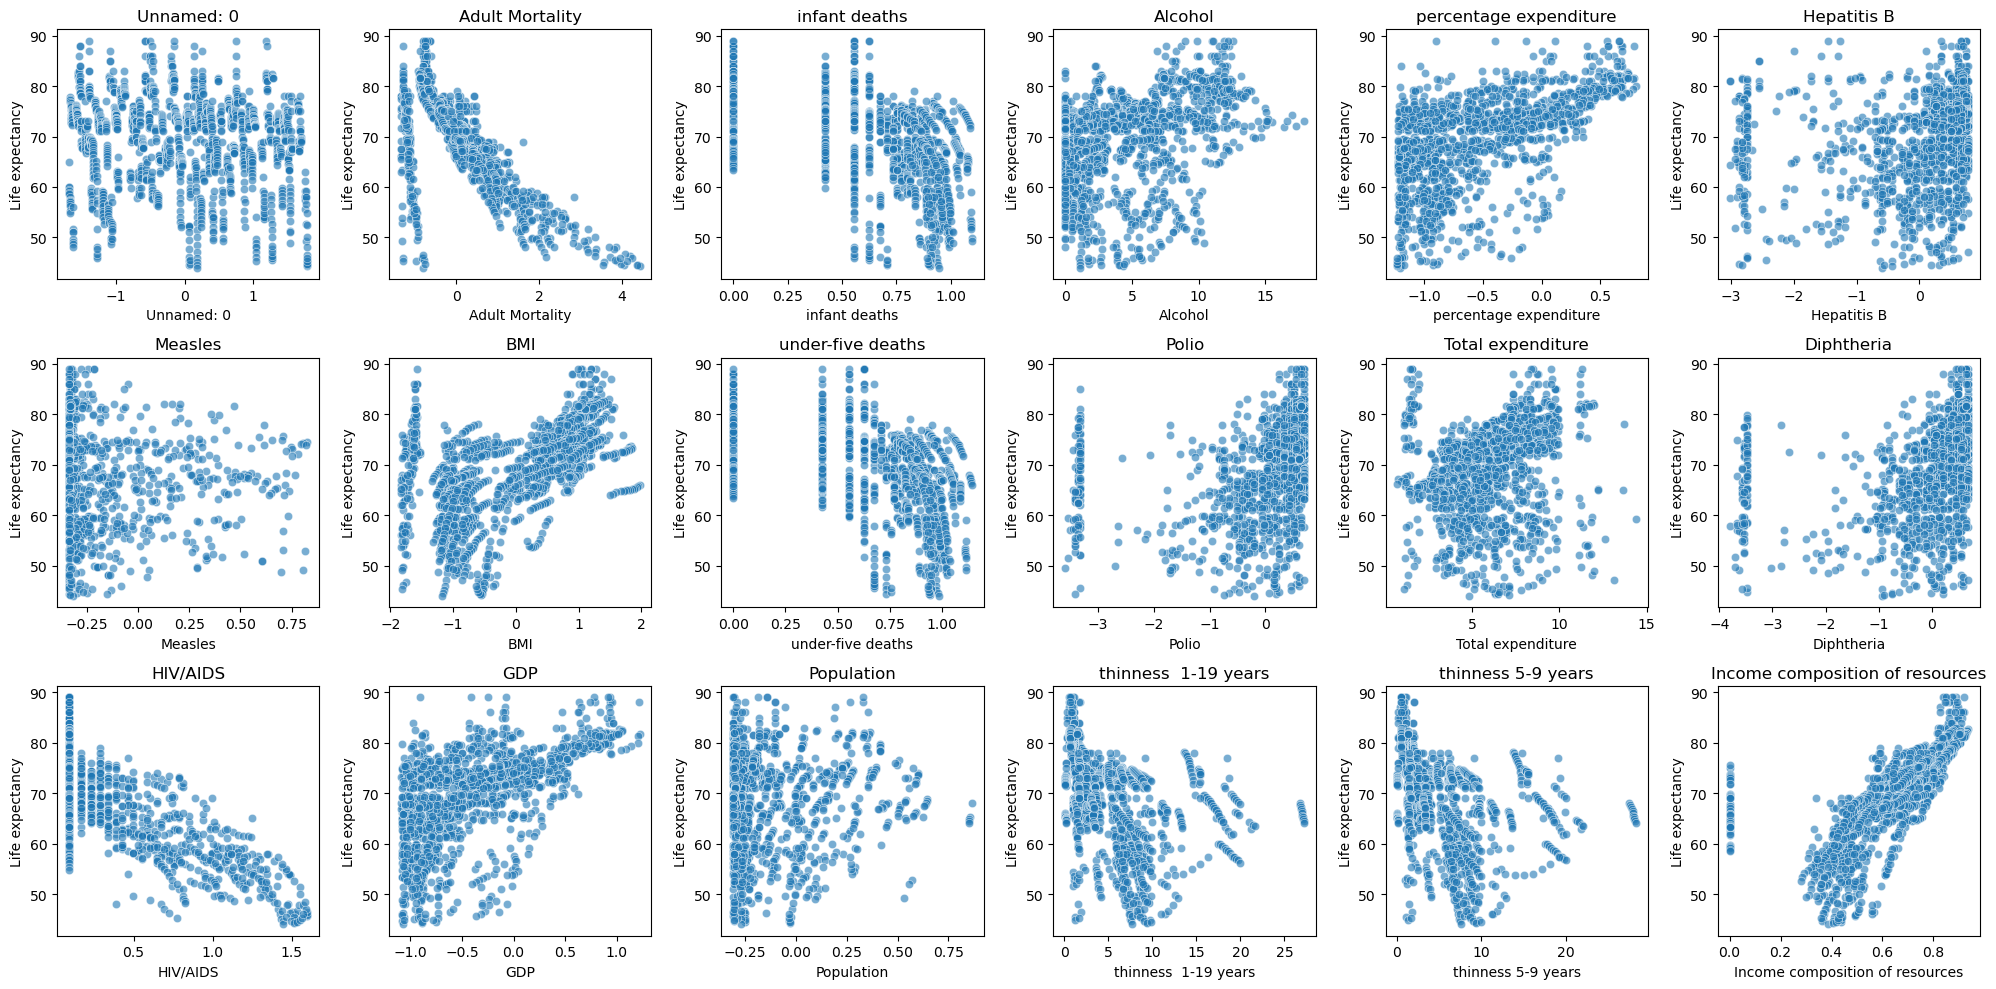

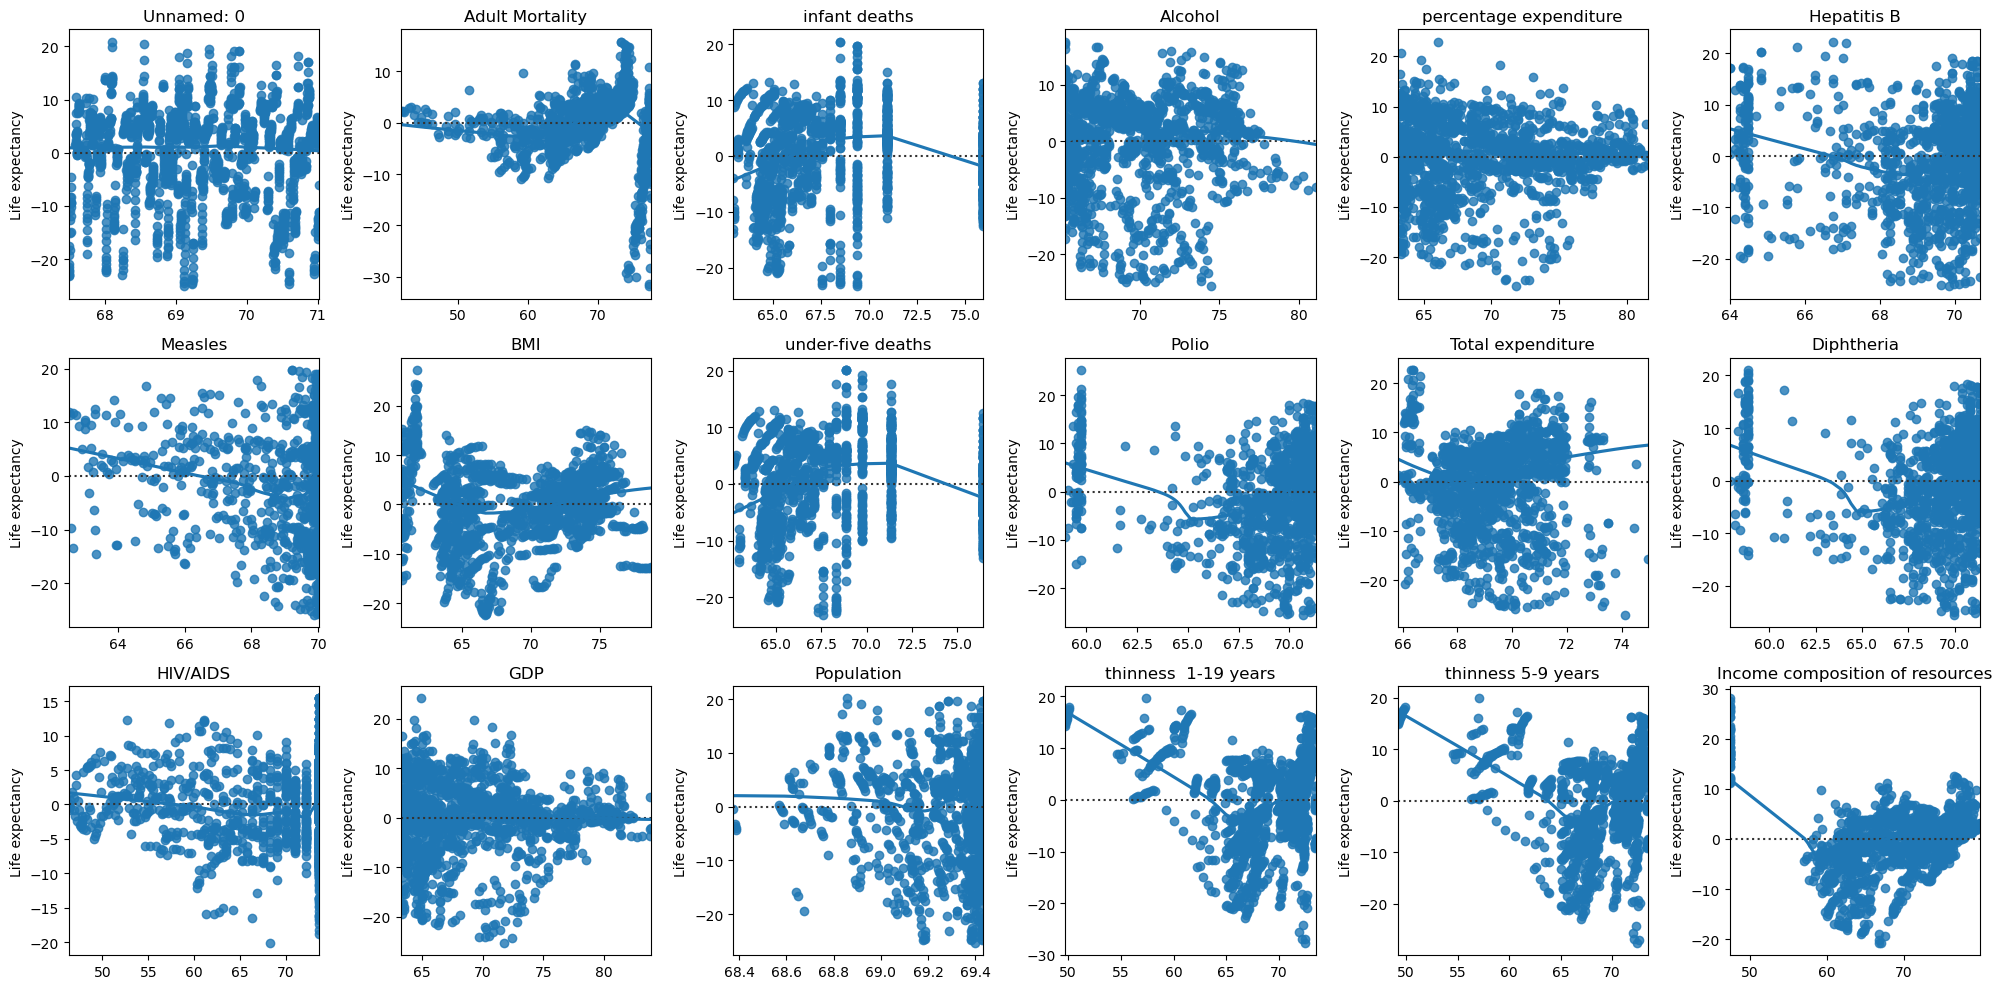

In [93]:
def assumptions_check(X, y):

    num_features = X.shape[1]
    rows, cols = 3, 6
    fig, axes = plt.subplots(rows, cols, figsize=(20, 10))
    
    # Scatter plots for linearity
    for i, feature in enumerate(X.columns):
        if i >= rows * cols:
            break
        sns.scatterplot(x=X[feature], y=y, ax=axes[i // cols, i % cols], alpha=0.6)
        axes[i // cols, i % cols].set_title(feature)
    
    plt.tight_layout()
    plt.show()
    
    # Residual plots for homoscedasticity
    fig, axes = plt.subplots(rows, cols, figsize=(20, 10))
    for i, feature in enumerate(X.columns):
        if i >= rows * cols:
            break
        coef = np.polyfit(X[feature], y, 1)
        predictions = np.polyval(coef, X[feature])
        residuals = y - predictions

        sns.residplot(x=predictions, y=residuals, ax=axes[i // cols, i % cols], lowess=True)
        axes[i // cols, i % cols].set_title(feature)

    plt.tight_layout()
    plt.show()

assumptions_check(X, y)

### Conclusions

- Linear Relationships: "Adult Mortality" and "Income composition of resources," show a clear trend with "Life expectancy," suggesting a linear relationship.
- Non-linear Patterns: some like "BMI" and "Total expenditure," the relationship with "Life expectancy" seems less clear or potentially non-linear, which might not fully satisfy the linearity assumption in linear regression.
- Weak or No Relationship: Features like "Measles" and "Polio" appear to have little to no clear trend with "Life expectancy," indicating they may not contribute much to predicting it linearly.
- Homoscedasticity: For some like "Adult Mortality" and "Income composition of resources," the residuals appear to have a roughly constant spread across predicted values, which supports homoscedasticity.
- Heteroscedasticity: Other features, like "thinness 1-19 years" and "Alcohol," show varying residual spread, indicating potential heteroscedasticity. This means the variance of residuals changes across the range of predictions, violating the homoscedasticity assumption.


__Overall Conslusion:__  
those who satisfy:  
Adult Mortality  
Income Composition of Resources  
BMI  
GDP  

In [94]:
model = LinearRegression()

model.fit(X_train, y_train)

y_train_pred = model.predict(X_train)
y_val_pred = model.predict(X_val)

# Performance Metrics

train_mse = mean_squared_error(y_train, y_train_pred)
val_mse = mean_squared_error(y_val, y_val_pred)
train_r2 = r2_score(y_train, y_train_pred)
val_r2 = r2_score(y_val, y_val_pred)

print("Training MSE:", train_mse)
print("Validation MSE:", val_mse)
print("Training R^2:", train_r2)
print("Validation R^2:", val_r2)

Training MSE: 10.97279751575863
Validation MSE: 11.230798162903788
Training R^2: 0.8607472410040619
Validation R^2: 0.8418698212975001


### According to previous analysis, some features can be removed and has potential to improve the performance

__descend with priority__  
- Those with little linearity with the response variable can be removed
-  Those are highly skewed can interfer the training due to the instability  
- Those do not satisfy homoscadecity assumption
-  Those with relatively higher correlation  
 
High variance attributes has been scaled so we do not consider

In [104]:
# We try removing Measles Total Expenditure Under-five first

X_train_reduced = X_train.drop(columns=['Measles', 'Total expenditure', 'under-five deaths'])
X_val_reduced = X_val.drop(columns=['Measles', 'Total expenditure', 'under-five deaths'])


model = LinearRegression()


model.fit(X_train_reduced, y_train)


y_train_pred_reduced = model.predict(X_train_reduced)
y_val_pred_reduced = model.predict(X_val_reduced)


train_mse_reduced = mean_squared_error(y_train, y_train_pred_reduced)
val_mse_reduced = mean_squared_error(y_val, y_val_pred_reduced)
train_r2_reduced = r2_score(y_train, y_train_pred_reduced)
val_r2_reduced = r2_score(y_val, y_val_pred_reduced)

print("Training MSE with reduced features:", train_mse_reduced)
print("Validation MSE with reduced features:", val_mse_reduced)
print("Training R^2 with reduced features:", train_r2_reduced)
print("Validation R^2 with reduced features:", val_r2_reduced)

Training MSE with reduced features: 11.018909488133792
Validation MSE with reduced features: 11.215085762516646
Training R^2 with reduced features: 0.8601620466298137
Validation R^2 with reduced features: 0.8420910526512316


### No significant performance improvement

In [105]:
# Then remove 'Measles', 'Total expenditure', 'under-five deaths'

X_train_reduced = X_train.drop(columns=['Measles', 'Total expenditure', 'under-five deaths'])
X_val_reduced = X_val.drop(columns=['Measles', 'Total expenditure', 'under-five deaths'])


model = LinearRegression()
model.fit(X_train_reduced, y_train)

y_train_pred_reduced = model.predict(X_train_reduced)
y_val_pred_reduced = model.predict(X_val_reduced)

train_mse_reduced = mean_squared_error(y_train, y_train_pred_reduced)
val_mse_reduced = mean_squared_error(y_val, y_val_pred_reduced)
train_r2_reduced = r2_score(y_train, y_train_pred_reduced)
val_r2_reduced = r2_score(y_val, y_val_pred_reduced)


print("Training MSE with reduced features:", train_mse_reduced)
print("Validation MSE with reduced features:", val_mse_reduced)
print("Training R^2 with reduced features:", train_r2_reduced)
print("Validation R^2 with reduced features:", val_r2_reduced)

Training MSE with reduced features: 11.018909488133792
Validation MSE with reduced features: 11.215085762516646
Training R^2 with reduced features: 0.8601620466298137
Validation R^2 with reduced features: 0.8420910526512316


### Still not

In [106]:
# Only leave 'Adult Mortality', 'Income composition of resources', 'BMI', 'GDP'

X_train_selected = X_train[['Adult Mortality', 'Income composition of resources', 'BMI', 'GDP']]
X_val_selected = X_val[['Adult Mortality', 'Income composition of resources', 'BMI', 'GDP']]

model = LinearRegression()
model.fit(X_train_selected, y_train)

y_train_pred_selected = model.predict(X_train_selected)
y_val_pred_selected = model.predict(X_val_selected)

train_mse_selected = mean_squared_error(y_train, y_train_pred_selected)
val_mse_selected = mean_squared_error(y_val, y_val_pred_selected)
train_r2_selected = r2_score(y_train, y_train_pred_selected)
val_r2_selected = r2_score(y_val, y_val_pred_selected)


print("Training MSE with selected features:", train_mse_selected)
print("Validation MSE with selected features:", val_mse_selected)
print("Training R^2 with selected features:", train_r2_selected)
print("Validation R^2 with selected features:", val_r2_selected)

Training MSE with selected features: 21.104370863901963
Validation MSE with selected features: 18.024319921736094
Training R^2 with selected features: 0.7321702268312881
Validation R^2 with selected features: 0.7462167079424902


### Comments

- original dataset has a balance between validation and training, means not overfitting
- 2nd and 3rd remains stable performance, meaning minimal impact of removing features
- last has significant decrease in both R square and MSE, meaning wrong direction, and suggests limitations in capturing the variability in the dataset

__Until now no significant improvement, which may reflects dataset properties__


### Intepretations and Judge
With an MSE of around 11 for both training and validation sets, the model’s predictions on life expectancy are reasonably close to actual values. An R² of around 0.86 indicates that about 86% of the variance in life expectancy can be explained by the model using the full set of features.
